# FORECASTING THE LOCAL ELECTRICITY PRICE AND THE VIABILITY OF INVESTING IN BATTERIES

## Executive Summary
### Future prices
- The electricity prices in Melbourne varied by more than a factor of two in the 5.5 years of data analyzed here. While there are seasonal and weekly regularities in the price and demand of electricity, these **seasonal effects only account for a small fraction of the variation in electricity prices**. This is likely due to the price of electricity following the prices of fossil fuels, which are still used to generate the majority of the electricity in the world. The price of fossil fuels on the other hand is tied to things like geopolitics and the state of the global economy, which are much more difficult to predict than the changing of the seasons.
- I expect electricity prices to return to at least 2017-2019 levels as the world economy recovers from the COVID pandemic. Thus we can expect an **average price of 102 AUD/ MWh** for Melbourne once the COVID pandemic subsides.
- There are two sesonal peaks in demand and price for electricity in Melbourne:
    - The **mean demand for electricity is highest during the Australian winter**, presumably due to increased electricity use in heating (the average low in June/July in Melbourne is around 8 C / 46 F). This is also reflected in the prices: at roughly 20% higher than the yearly average, the mean electricity price shows a peak in June and July compared to the fall and spring months
    - The **highest peak demand occurs during the heat of summer**, when people crank up the air conditioning on days with highs of more than 40 degrees celcius. The electricity production in Melbourne doesn't always seem to be able to keep up with demand on these days, and prices skyrocket. This results in the prices in January being approximately 50% higher than the yearly average, and with **large daily variance in both demand and prices**. This is good news from the point of view of solar arrays, since their production will be at a maximum on sunny summer days.
- The expected mean prices for each month are shown in the plot below. The black lines on each bar are proportional to the variance in prices for each month.

![Expected prices for each mont](./figures/expected_prices.jpg)

- Demand and price also vary by day of week: on weekdays the demand and price are higher than during the weekend or on holidays. For demand, the difference is approximately 10%, for prices around 25%. The variation in prices is shown in the figure below.

![Price by day of the week](./figures/week_vs_weekend.jpg)

- For estimating the prices for the next 12-18 months, I recommend using the average price of 102 AUD/ MWh that was seen before the pandemic, and to scale that price by the monthly relative price. If one is interested in a particular day, whether or not the day is a weekend/holiday or a working day should be taken into account. 
- Since the seasonal effects explain only a small part of the price variation, to truly make accurate long term predictions we would need more data. The most important would probably be something that indicates long term pricing of fossil fuels, such as oil or gas futures.
- The return-on-investment for solar arrays Victoria seems very good: somewhere between 12-38% based on a quick estimate.

### Battery storage to buy low, sell high
- Battery storage is not financially viable at current electricity prices, battery costs and battery lifetimes:
    - 70 MWh lithium-ion battery would **cost 12 million AUD at a minimum**
    - With perfect information on tomorrow's electricity prices, the battery system could make a **profit of 300,000 AUD per year**, assuming we sell at mean daily prices.
    - **Yearly ROI is then 2.6%** - much more profitable to spend money on more solar panels rather than batteries
    - Battery system would take almost 40 years to pay back for itself. Lithium-ion batteries can last up to 3,500 charge-discharge cycles which would be just under 10 years if done daily. In our case the cycling might only occur every two days or so, but the batteries would still not be able to pay for themselves.
    - With minimal tuning, a **machine learning model (LightGBM, a gradient boosted tree regressor) can predict price differences between today's and tomorrow's prices well enough to make 48% of the maximum theoretical profit**. With some effort this can surely be improved, so that predicting when to store and when to sell electricity should not be a problem.
- Once the price of battery capacity comes down by a factor of four, it may start to become more profitable than solar panels
- Analysis of battery storage here assumed electricity is sold at mean daily price - profitability may be much improved if the electricity is sold during peak hours. I still would not expect this to be more than a factor of two increase in the yearly profit, making investing in solar arrays the better option for now.

📖

# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 INTRODUCTION
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

## DATA WRANGLING

### VISUAL AND PROGRAMMATIC ASSESSMENT

In [12]:
#!pip install lightgbm

In [13]:
%%capture
# IMPORT PACKAGES AND LIBRARIES

import warnings
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Tuple, Union
from itertools import product
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [14]:
# import data
energy = pd.read_csv('energy_demand.csv', parse_dates=['date'])
energy.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


The data type of school_day and holiday columns should be converted to categorical type. All other columns have the correct data type

In [15]:
# check summary statistics
energy.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


In [16]:
# check for duplicates
energy.duplicated().any().sum()

0

### DATA CLEANING

We would not be dropping any rows but we will convert 

In [17]:
# make a copy of the data before cleaning
energy_dmd = energy.copy() 

#### DEFINE
convert school_day and holiday to bool type


#### CODE

In [18]:
# convert data types
dict_map_yn_bool = {'yes':True, 'no':False}
replace_dict = {'school_day':dict_map_yn_bool, 
           'holiday':dict_map_yn_bool}
energy_dmd = energy_dmd.replace(to_replace=replace_dict)
energy_dmd[['holiday', 'school_day']] = energy_dmd[['holiday', 'school_day']].astype('bool')

#### Test

In [19]:
energy_dmd[['school_day', 'holiday']].dtypes

school_day    bool
holiday       bool
dtype: object

## DATA PREPARATION

+ we would extract the month, day and year from the date column
+ convert solar_exposure from MJ/m^2 to MWh/m^2
+ perform some feature engineering
+ set date as index

In [20]:
# extract year, month, day of the week and week
# from date column
energy_dmd['day'] = energy.date.dt.day_name()
energy_dmd['month'] = energy.date.dt.month
energy_dmd['year'] = energy.date.dt.year
energy_dmd['week'] = energy.date.dt.isocalendar().week.astype('int')

In [21]:
# Convert solar exposure from MJ/m^2 to MWh/m^2 
# (1 MJ = 1/(60*60) MWh)
energy_dmd.solar_exposure = energy_dmd.solar_exposure/3600

# Set date as index so can do resampling using pandas
energy_dmd.set_index('date', inplace=True)

## EXPLORATORY DATA ANALYSIS

### The distribution of price is rightly skewed
most of the data are to the riht of the graph. This can be due to the data set lower bound being too low relative to the rest of the data or as a result of start-up effect ( a situation whereby the company had great successes or recorded more profit during its long startup period). My assumption is that the business recorded greater profit in the beginning than now. This means that the mean, median, and mode are all different with the mean being the greatest. In this case, the mode is the highest point of the histogram, whereas the median and mean fall to the right of it (or, visually, the right of the peak)

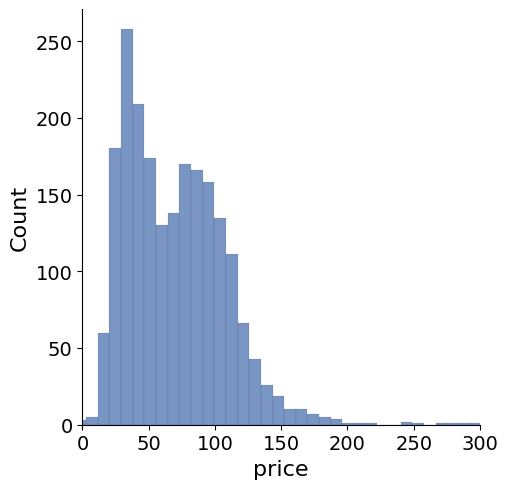

In [22]:
# plot histogram of price 

sns.displot(energy_dmd['price'])

# set axis limit
plt.xlim(0, 300);

## The distribution of demand closely follows a normal distribution
This is not suprising as there is a general notion that demand is normally-distributed. For all normal distributions, 68.2% of the observations will appear within plus or minus one standard deviation of the mean; 95.4% of the observations will fall within +/- two standard deviations; and 99.7% within +/- three standard deviations. The mean, median and mode will be approximately equal.

<Figure size 1600x900 with 0 Axes>

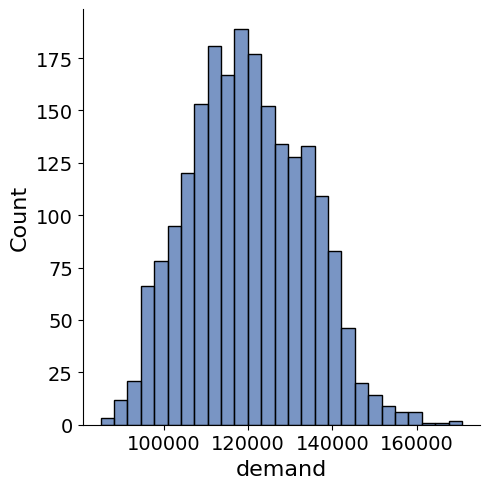

In [23]:
# plot histogram of demand
plt.figure(figsize = [16,9])
sns.displot(energy_dmd['demand'])

# set axis limit
#plt.xlim(0, 300);

# Time Series Decomposition

we decompose the time series using seasinal-trend decomposition using LOESS (STL).

## DEMAND

## Trend Analysis
There is a general downward trend in demand of electricity in the city of melbourne even before the advent the corona virus and the lockdown. The demand is observed to increase from march down till june before it starts to descrease again between july till the end of the year.

## Seasonality Analysis
There is always a peak in demand in the middle of the year. This might be due to the hot weather and air conditioning being needed more hence the rise in demand for electricity

Text(0.5, 0.98, 'Time Series Decomposition of Demand')

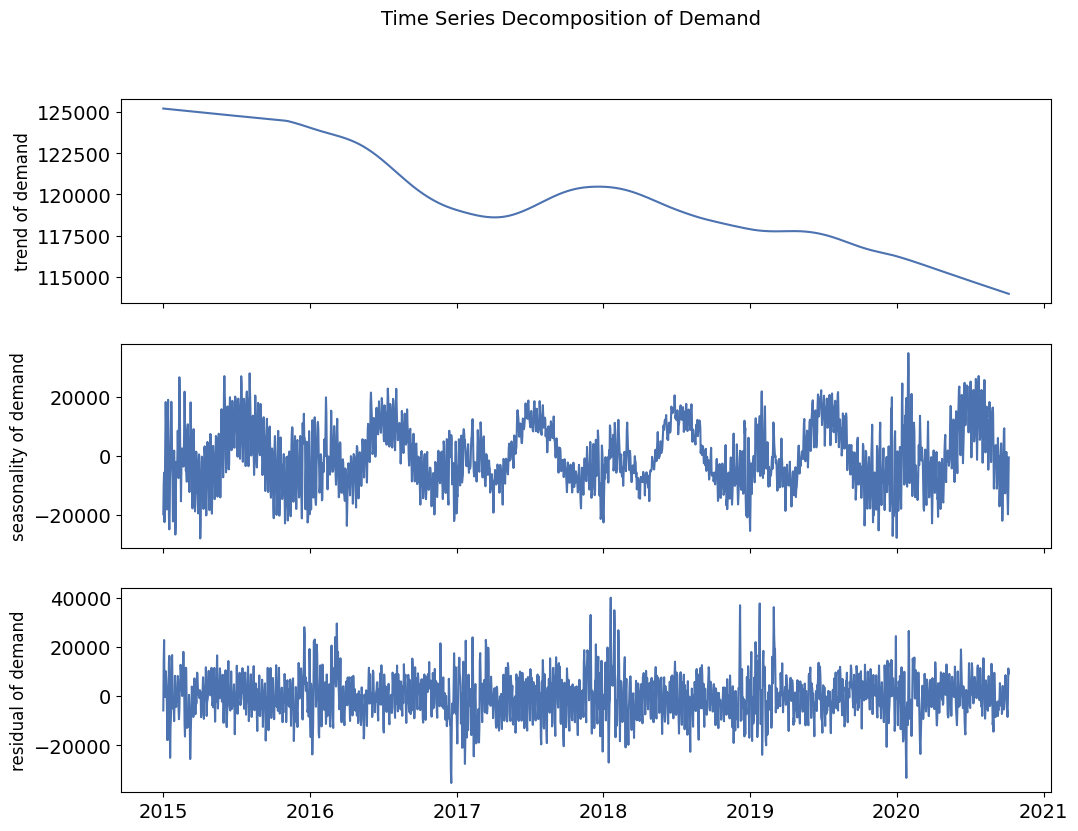

In [24]:
# import the package 
from statsmodels.tsa.seasonal import STL
# instantiate the model
stl_demand = STL(energy_dmd['demand'], period = 365, seasonal = 13).fit()
# create the subplots and plot each component
# set axis and title labels
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,
                              figsize=(12,9), sharex=True)
ax1.plot(stl_demand.trend)
ax1.set_ylabel('trend of demand', fontsize = 12)

ax2.plot(stl_demand.seasonal)
ax2.set_ylabel('seasonality of demand', fontsize = 12)
ax3.plot(stl_demand.resid)
ax3.set_ylabel('residual of demand', fontsize = 12)
fig.suptitle('Time Series Decomposition of Demand', fontsize = 14)

#plt.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood decommissioned')


## PRICE

## Trend
The price has been increasing from the start of the business and reached it peak in 2019 between may and june before we start to observe a very steady and then sharp decline in price in the month of April 

## Seasonality
The price of electricity always peaks in the first quarter of the year as it was observed starting from 2016 with each peak higher than that in the previous year. This always occurs towards the end of jauary (January 28). 

we will do an indepth analysis as we go further on the trend and seasonality

Text(0.5, 0.98, 'Time Series Decomposition of Price')

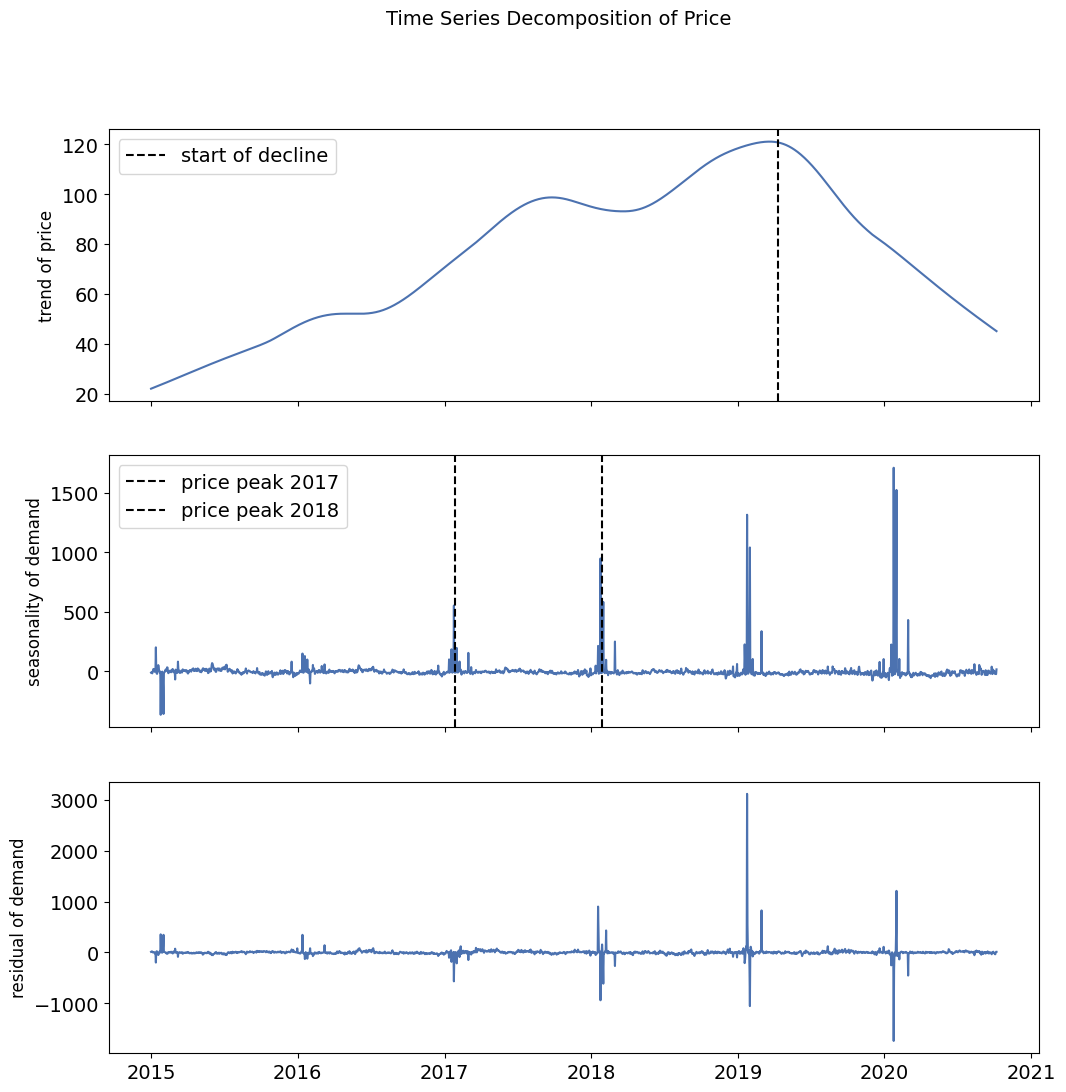

In [25]:
stl_price = STL(energy_dmd['price'], period = 365, seasonal = 13).fit()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1,
                              figsize=(12,12)
                                      , sharex=True)
ax1.plot(stl_price.trend)
ax1.set_ylabel('trend of price', fontsize = 12) 
ax1.axvline(pd.Timestamp('2019-4-10'), ls = '--', c = 'k', label = 'start of decline')
ax1.legend()
ax2.plot(stl_price.seasonal)
ax2.set_ylabel('seasonality of demand', fontsize = 12)
ax2.axvline(pd.Timestamp('2017-1-28'), ls = '--', c = 'k', label = 'price peak 2017')
ax2.axvline(pd.Timestamp('2018-1-28'), ls = '--', c = 'k', label = 'price peak 2018')
ax2.legend()
ax3.plot(stl_price.resid)
ax3.set_ylabel('residual of demand', fontsize = 12)

fig.suptitle('Time Series Decomposition of Price', fontsize = 14)


## Electricity Price Variation in melbourne Jan 1, 2015 - Oct 6, 2020

The plot below shows the weekly median price of electricity as well as the range(min -max values) that is shown by the shaded region, The following things should be noted:

+ The price of electricity increased significantly during the first quarter of 2017, and stayed at this level for the next 2.5 years. The increase in price coincides with the closure of the Hazelwood coal power station, shown by the dashed line in the figure. It seems likely that the higher price is due to switching from coal to natural gas which is cleaner but more expensive.

+ The price of electricity started going down already before the advent of COVID pandemic (start of lockdown in Victoria is shown by the dot-dashed line in the figure), and is expected to stay low while economic activity is decreased due to the COVID lockdown. Once the pandemic subsides, the price is likely to go up again as oil, gas and coal producers struggle to keep up with demand, having decreased production during the pandemic.

+ There are a number of days in the Australian summer (mostly in January) where the price is 10s times the median weekly price. This seems to indicate that on very hot days, electricity production in Melbourne is not able to keep up with the demand for air conditioning units working on overdrive. Solar arrays will be of good use during these times as there will be maximum electricity being generated from the solar arrays.

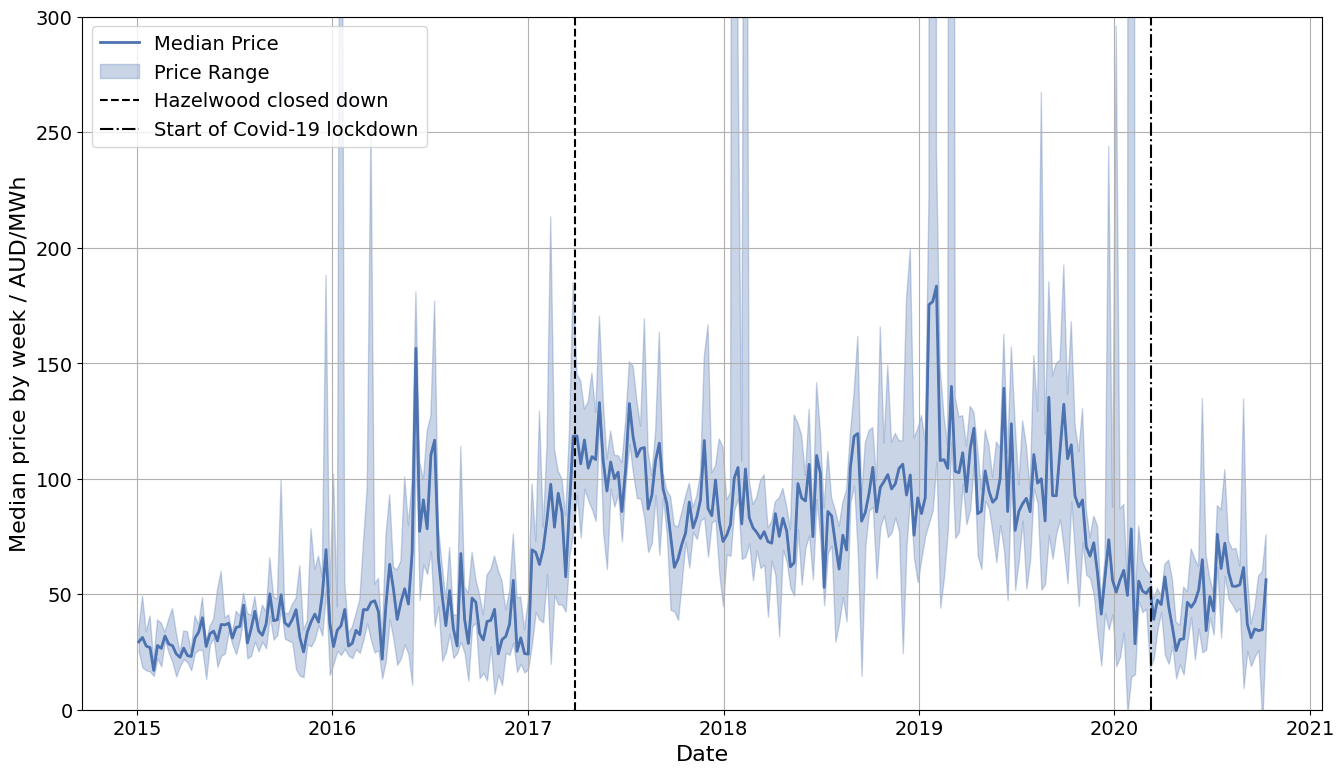

In [26]:
fig, ax =  plt.subplots()

# calculate weekly statistics of price
weekly_median_price = energy_dmd.resample('1W').price.median()
weekly_max_price = energy_dmd.resample('1W').price.max()
weekly_min_price = energy_dmd.resample('1W').price.min()

# plot the time series filling it with some 
# calculated statistics
ax.plot(weekly_median_price.index, weekly_median_price, lw = 2, label = 'Median Price')
ax.fill_between(weekly_median_price.index, weekly_max_price,\
                weekly_median_price, alpha = 0.3,\
                color = 'C0', label = 'Price Range')
ax.fill_between(weekly_median_price.index, weekly_min_price,\
                weekly_median_price, alpha = 0.3,\
                color = 'C0')

# annotate the plot to show significant events
# that led to variation in price
ax.axvline(pd.Timestamp('2017-3-29'), ls = '--', c = 'k', label = 'Hazelwood closed down')
ax.axvline(pd.Timestamp('2020-3-10'), ls = '-.', c = 'k', label = 'Start of Covid-19 lockdown')

# set axis labels and titles
ax.set_ylabel('Median price by week / AUD/MWh')
ax.set_xlabel('Date')
ax.set_ylim([0, 300])
ax.legend()
ax.grid()

- As shown below, these changes in price seem to be driven by variations in demand: higher demand results in higher prices as one might expect based on basic economics.
- Average demand is highest during the winter, but peak daily demand is reached during the summer.
- The peak prices and demand occur during the hottest days in the data so they are likely due to electricity demand from air conditioning outstripping supply.
- Solar arrays produce the most electricity during the summer when they get more sun exposure, so they would be able to supply electricity when it is at its most valuable during hot, sunny days.

### Variation in demand
The plot below shows the seasonal variation in demand for electricity. The average demand is highest during the Australian winter (peaking around June and July), presumbaly due to electrical heating. The highest peak demand, however, is during the summer on very hot days where the need for air conditioning causes a surge.


Text(0.5, 0, 'Month')

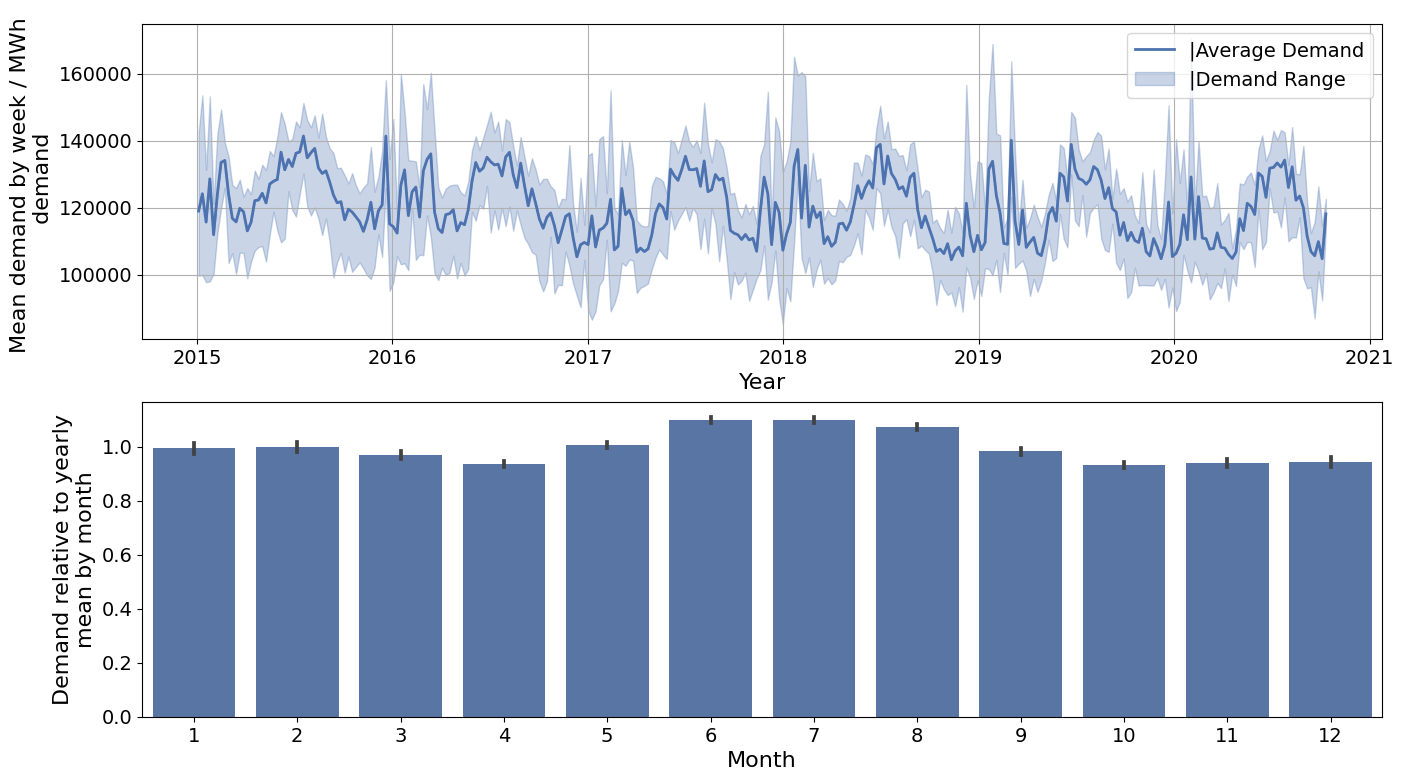

In [27]:
fig, (ax,ax_bar) = plt.subplots(2,1)

# plot the time series filling it with some 
# calculated statistics
sample_window = '1W'
weekly_mean_dmd = energy_dmd.resample(sample_window).demand.mean()
weekly_max_dmd = energy_dmd.resample(sample_window).demand.max()
weekly_min_dmd = energy_dmd.resample(sample_window).demand.min()

ax.plot(weekly_mean_dmd.index, weekly_mean_dmd, lw = 2, label = '|Average Demand')
ax.fill_between(weekly_mean_dmd.index, weekly_max_dmd,\
                weekly_mean_dmd, alpha = 0.3,\
                color = 'C0', label = '|Demand Range')
ax.fill_between(weekly_mean_dmd.index, weekly_min_dmd,\
                weekly_mean_dmd, alpha = 0.3,\
                color = 'C0')

# set axis labels and titles
ax.set_ylabel('Mean demand by week / MWh \n demand')
ax.set_xlabel('Year')
ax.legend()
ax.grid(True)

# create a new data containing a grouped statistical measure
yearly_means = energy_dmd.groupby('year').demand.mean().to_frame('mean_yearly_demand')
energy_group = energy_dmd.copy()
energy_group = energy_group.merge(yearly_means, on = 'year')
energy_group['relative_demand'] = energy_group.demand/energy_group.mean_yearly_demand

# plot a bar chart
ax_bar = sns.barplot(data = energy_group, y = 'relative_demand',\
                     x = 'month', estimator = np.mean, \
                     color = 'C0')
ax_bar.set_ylabel('Demand relative to yearly\nmean by month')
ax_bar.set_xlabel('Month')

### Correlation between demand and price
The plot below shows the correlation between electricity price and demand. Higher demand results in a higher price, as one might expect based on basic economics. The demand explains roughly 25% of the variance in the prices. Since the correlation is fairly weak, the seasonal variations are difficult to see by eye when plotting the price over time, even though the demand has clear seasonal variation.

Correlation coefficient between demand and price: 0.259


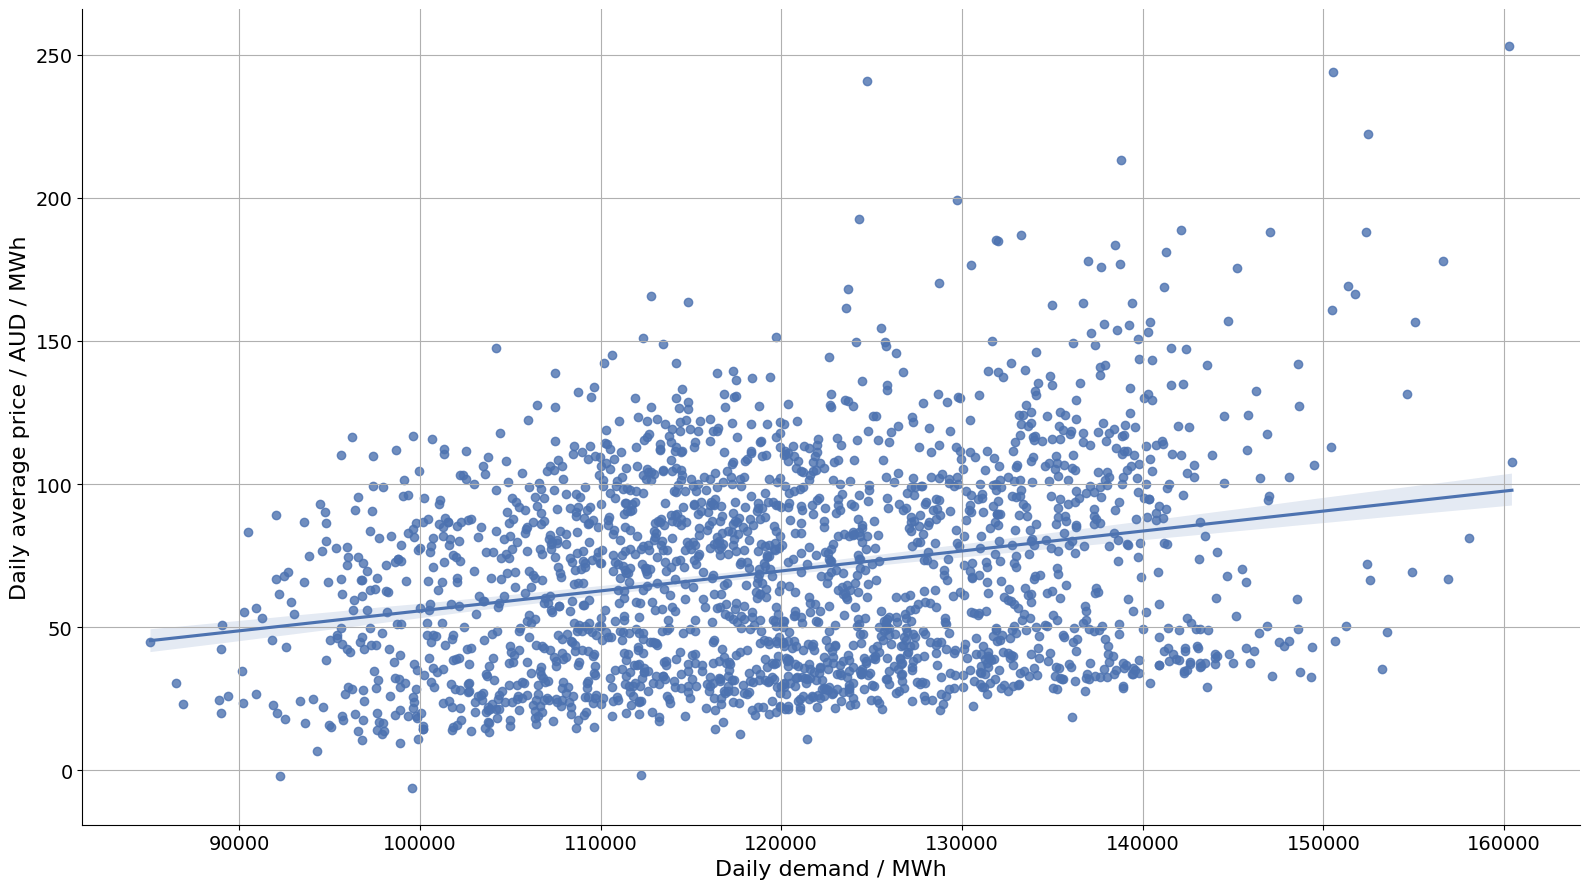

In [28]:
# Draw a regression plot
grid = sns.lmplot(data = energy_dmd[energy_dmd.price < energy_dmd.price.median()*4],\
                  x = 'demand', y = 'price', \
                  height = 9, aspect = 16/9, )

# set axis labels and title
grid.axes[0,0].set_xlabel('Daily demand / MWh')
grid.axes[0,0].set_ylabel('Daily average price / AUD / MWh')
grid.axes[0,0].grid(True)

# calculate the correlation coefficient
energy_no_outliers = energy_dmd[energy_dmd.price < 4*energy_dmd.price.median()]
corr_coeff = energy_no_outliers[['demand']].corrwith(energy_no_outliers.price)
print(f"Correlation coefficient between demand and price: {corr_coeff[0]:.3f}")

## Seasonal variation in relative price
To better see the variation in price by season, we can plot the average monthly prices normalized by the average price for the year, as done in the barplot below. 

Observations:
- The mean price of electricity is the highest during January. As mentioned before, this is due to days of extreme heat, during which the demand for electricity (probably due to air conditioning) outstrips supply causing prices to surge.
- During the coldest part of the year (June-July), the mean price is also slightly higher than the rest of the year. This is likely due to heating increasing demand for electricity.

Text(0.5, 0, 'Month')

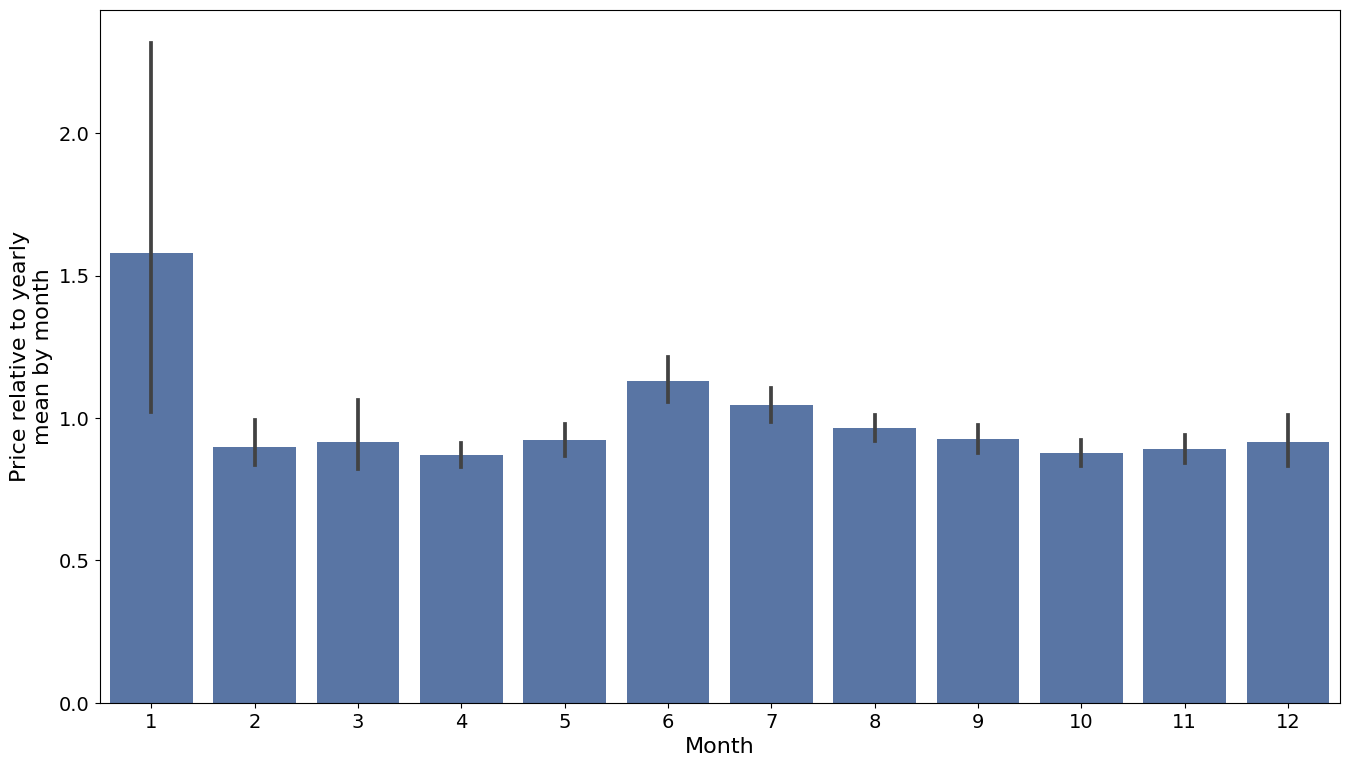

In [29]:
# create a new data containing a grouped statistical measure
yearly_means_price = energy_dmd.groupby('year').price.mean().to_frame('mean_yearly_price')
energy_group_price = energy_dmd.copy()
energy_group_price = energy_group_price.merge(yearly_means_price, on = 'year')
energy_group_price['relative_price'] = energy_group_price.price/energy_group_price.mean_yearly_price

# plot a bar chart
ax_bar = sns.barplot(data = energy_group_price, y = 'relative_price',\
                     x = 'month', estimator = np.mean, \
                     color = 'C0')
ax_bar.set_ylabel('Price relative to yearly\nmean by month')
ax_bar.set_xlabel('Month')

### Seasonal variation in prices and the value of electricity produced by solar arrays
The solar exposure varies greatly during the year in Melbourne, as shown by the plot below. There are also days during the summer when the solar exposure is low, presumably due to cloud cover.

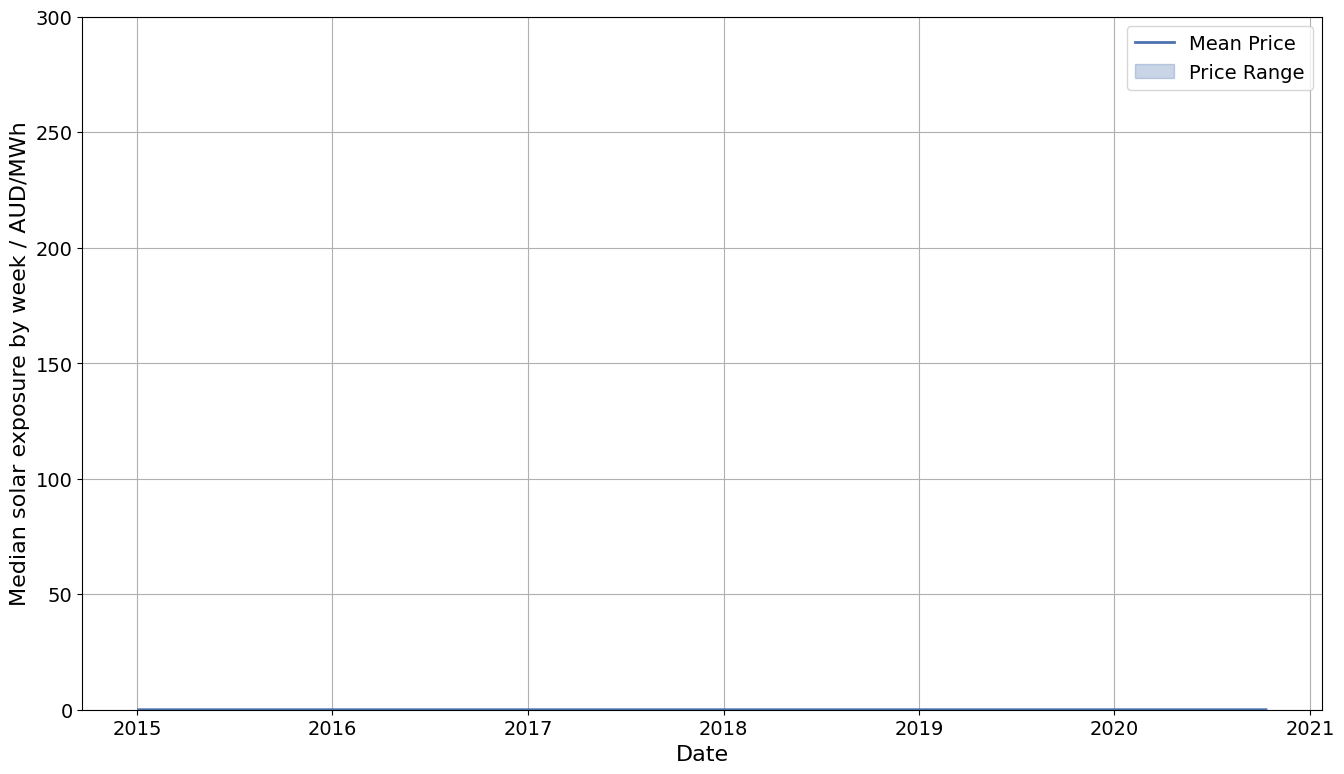

In [30]:
fig, ax =  plt.subplots()

# calculate weekly statistics of price
weekly_mean_solar = energy_dmd.resample('1W').solar_exposure.median()
weekly_max_solar = energy_dmd.resample('1W').solar_exposure.max()
weekly_min_solar = energy_dmd.resample('1W').solar_exposure.min()

# plot the time series filling it with some 
# calculated statistics
ax.plot(weekly_mean_solar.index, weekly_mean_solar, lw = 2, label = 'Mean Price')
ax.fill_between(weekly_mean_solar.index, weekly_max_solar,\
                weekly_mean_solar, alpha = 0.3,\
                color = 'C0', label = 'Price Range')
ax.fill_between(weekly_mean_solar.index, weekly_min_solar,\
                weekly_mean_solar, alpha = 0.3,\
                color = 'C0')

# set axis labels and titles
ax.set_ylabel('Median solar exposure by week / AUD/MWh')
ax.set_xlabel('Date')
ax.set_ylim([0, 300])
ax.legend()
ax.grid()

## Variations during the week: weekdays vs weekend
The demand and price show a clear trend during the week: from Monday to Tuesday and friday to sunday sees approximately 10% more demand than the mid days (wednesday and thurday). The same trend is seen in the price although with just slight difference. Looking at the two plots, price is seen to follow demand.

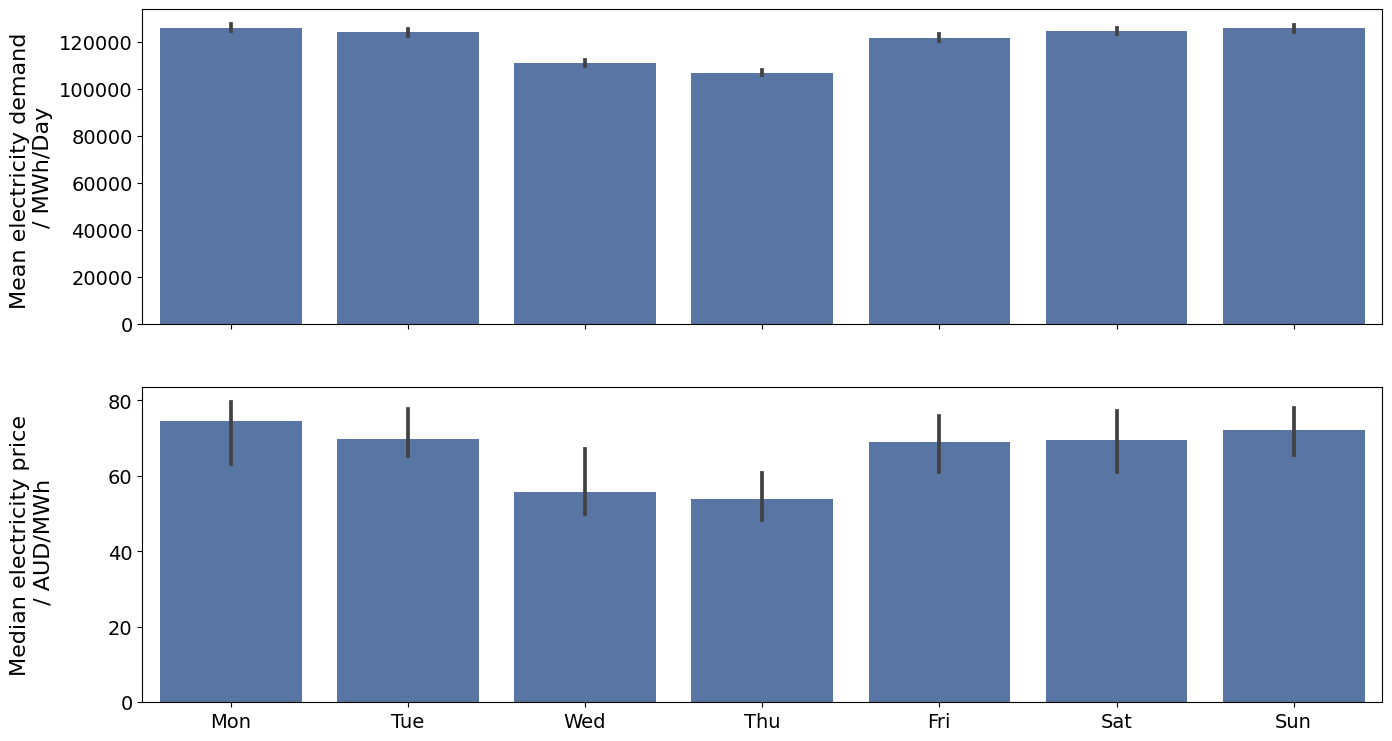

In [31]:
# create a subplot
fig, (ax, ax2) = plt.subplots(2,1, sharex = True)

# draw a bar plot to show average monthly demand
# across the various years and label the axis and titles
ax = sns.barplot(data = energy_dmd, x = 'day',\
                 y = 'demand', color = 'C0', \
                 estimator = np.mean, ax = ax)
ax.set_xlabel('')
ax.set_ylabel('Mean electricity demand \n/ MWh/Day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# draw a bar plot to show median monthly demand
# across the various years and label the axis and titles
ax2 = sns.barplot(data = energy_dmd, x = 'day',
                  y = 'price', estimator = np.median,
                  color = 'C0', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Median electricity price\n / AUD/MWh')
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
fig.align_ylabels([ax, ax2])

## Variation of demand year to year
2020 is excluded from the plot as the there is not enough information to accurately calculate the average demand. We can see a steady decline in the average yearly demand from 2015 to 2016 but there seem to be a uniform average between 2017 and 2018. The reduction in the average demand in 2019 might be due to the covid-19 pandemic.

Text(0.5, 0, 'Year')

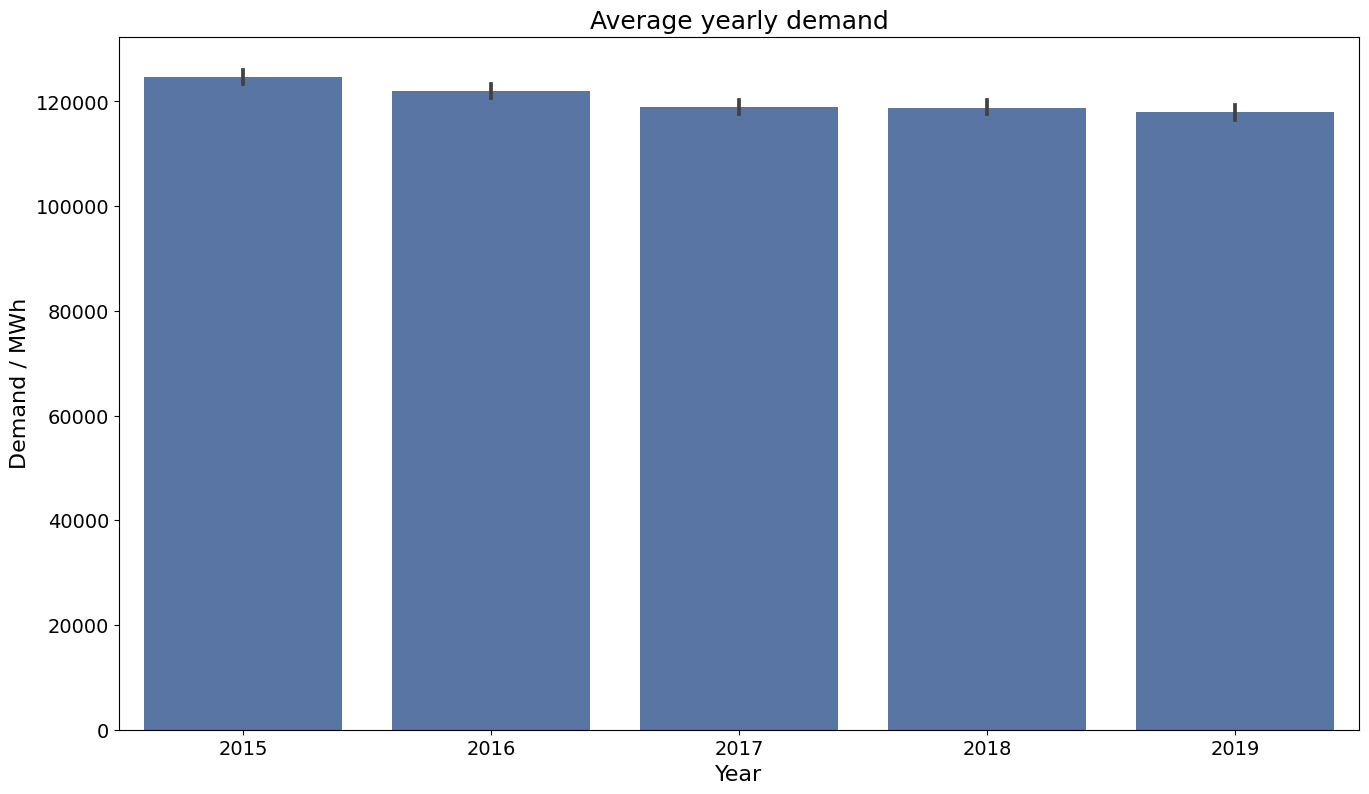

In [32]:
# draw a bar plot to show average yearly variation in demand 
# and label axis and titles
ax = sns.barplot(data = energy_dmd[energy_dmd.year != 2020], y = 'demand',\
                 x = 'year', estimator = np.mean,\
                 color = 'C0')
ax.set_title('Average yearly demand')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Year')

## Variation in Average Yearly Price
The median price in the year 2015 to 2016 was low compared to the years that follow. The low prices seems to be due to the fact that there are alternatives to solar and the company is just starting to sell. we will see that the price jumped up in 2017 by more than 50% on average due to solar energy gaining popularity and serving as a very reliable source of clean energy.

Text(0.5, 0, 'Year')

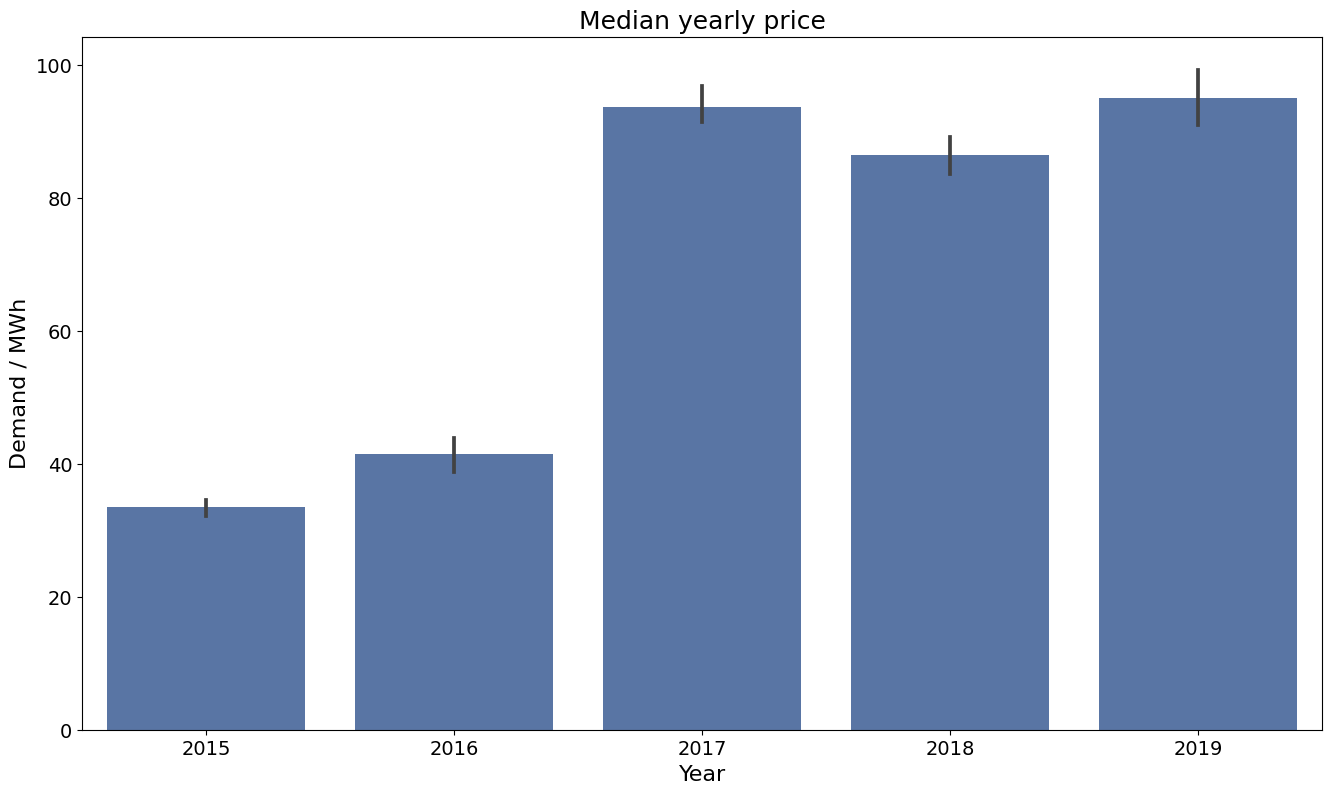

In [33]:
# draw a bar plot to show average yearly variation in price 
# and label axis and titles
ax = sns.barplot(data = energy_dmd[energy_dmd.year != 2020], y = 'price',\
                 x = 'year', estimator = np.median,\
                 color = 'C0')
ax.set_title('Median yearly price')
ax.set_ylabel('Demand / MWh')
ax.set_xlabel('Year')

## There is non-linear relatioship between price and temperature

Even though the Regression plot shows a non-linear relation between price and temperature, There seems to be a surge in price when the temperature goes above 30 degrees celcius. 

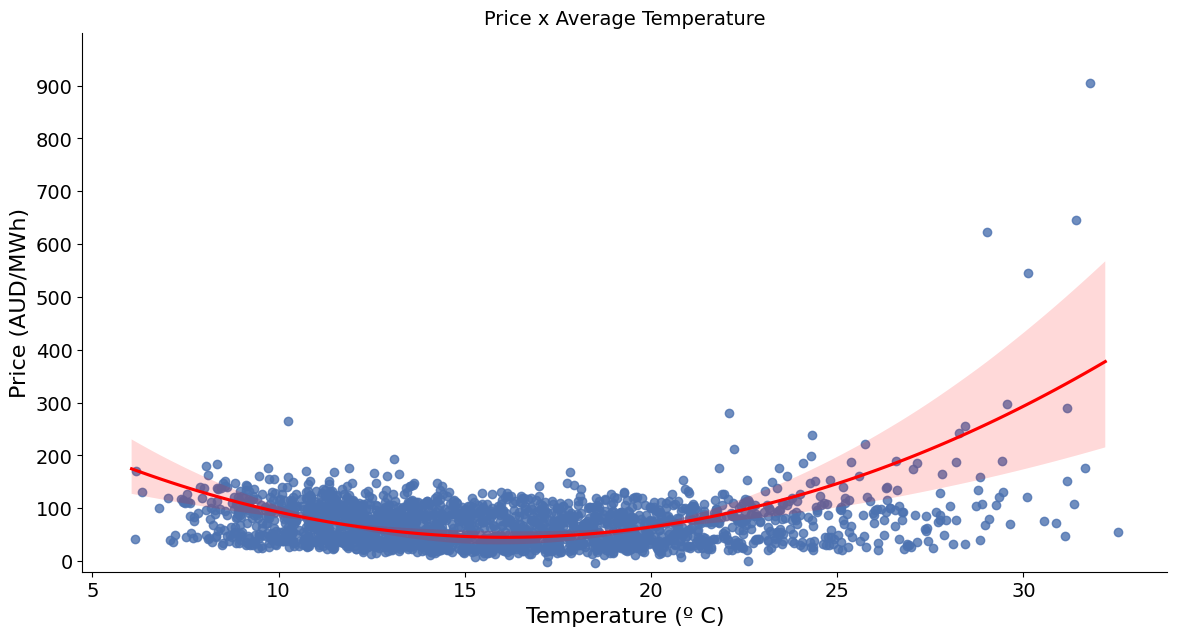

In [34]:
# minimum and maximum temperature x price
data = energy_dmd[['price', 'max_temperature', 'min_temperature']]
data['avg_temp'] = (data['max_temperature'] + data['min_temperature'])/2

fig, ax = plt.subplots(figsize=(14,7))

sns.regplot(data=data, x='avg_temp', y='price', order=2, ax=ax,
            line_kws={'color': 'red'}, x_jitter = 1,\
           y_jitter = 3)


# set axis labels and title
ax.set_xlabel('Temperature (º C)')
ax.set_ylabel('Price (AUD/MWh)')
ax.set_yticks([i for i in range(0, 1000, 100)])

plt.title('Price x Average Temperature', fontsize=14)
plt.ylim(-20, 1000)
sns.despine()
plt.show()

## Electricity generated from the solar array traded at negative price for 191 days


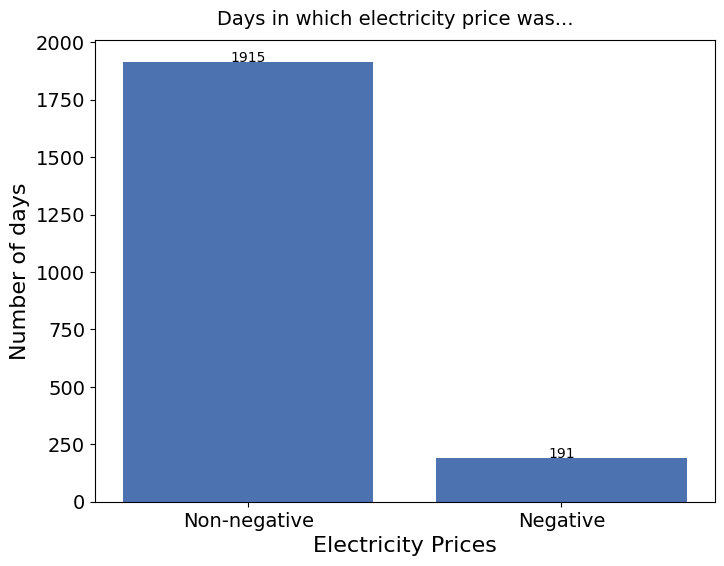

In [35]:
# filter the data for non-negative prices
filt = energy_dmd['frac_neg_price'] > 0

fig, ax = plt.subplots(figsize=(8,6))

# set up the data to plot and plot the bar graph
x = ['Non-negative', 'Negative']
y = [energy_dmd[~filt].shape[0], energy_dmd[filt].shape[0]]
ax.bar(x=x,
      height=y)

# label axis
ax.set_xlabel("Electricity Prices")
ax.set_ylabel("Number of days")

# annotate the bars to give actual count of days
for i, value in enumerate(y):
    plt.text(x=i, y=value+1, s=str(value), ha='center')

# title
plt.suptitle("Days in which electricity price was...", y=0.93, fontsize=14)
plt.show()

##  Most days only traded negatively for less than 6 hours
We see that most days with negative prices are only so for less than 6 hours (roughly 93.71% of the days). Nevertheless, it's a substantial fraction of the day that can lead to bad results if not anticipated. Now that we know for how long during the day electricity trades for negatively, it's time to understand why it does so. Is there a pattern for these occurrences? One thing to notice is how there was a surge in these points from mid-2019 onwards, perhaps indicating a public move towards renewable energy (solar panels at home, more so as pandemic restrictions were enforced and led to homeworking).

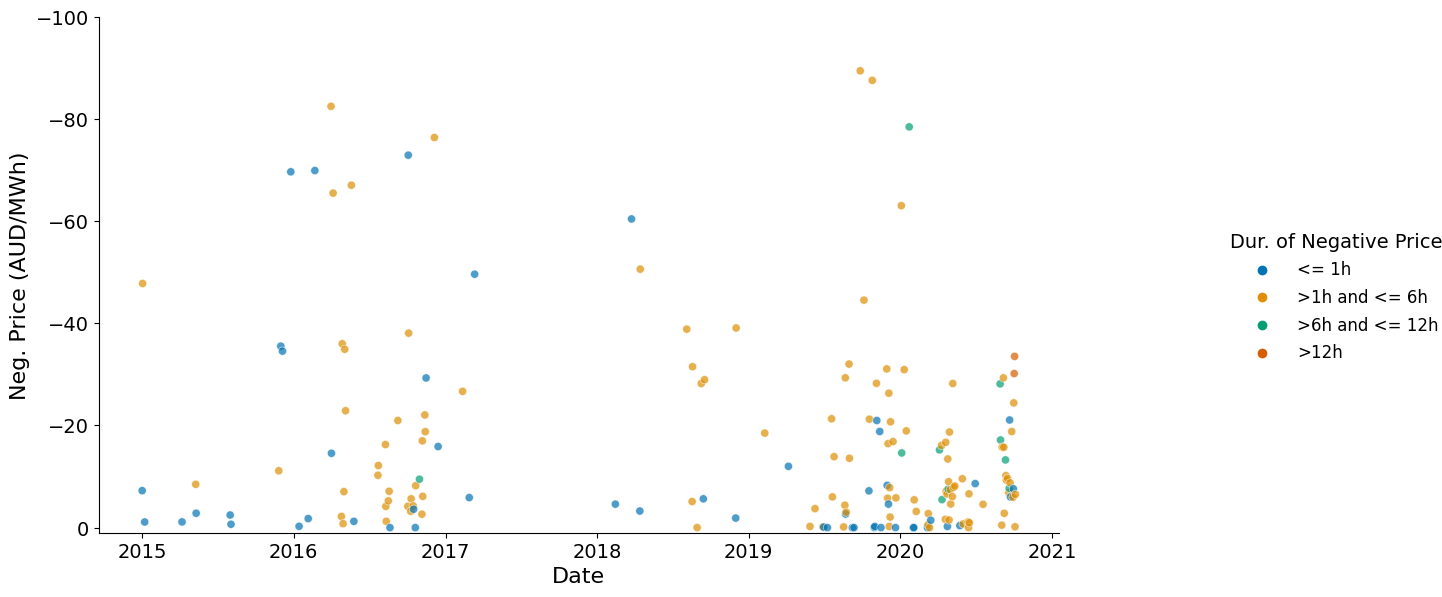

In [36]:
# create a function that map negative prices to the 
# number of hours traded at negative
def map_fraction_of_day(frac_neg):
    '''
    a function that map negative prices to the 
    number of hours traded at negative 
    @ frac_neg : fraction of time price traded at negative
    '''
    # create a dictionary
    frac_dict = {1/24: '<= 1h',
                1/4: '>1h and <= 6h',
                1/2: '>6h and <= 12h',
                1: '>12h'}
    
    # loop through the dictionary to see values that matches with
    # that in the data and return the corresponding key
    for key in frac_dict.keys():
        if frac_neg <= key:
            return frac_dict[key]

# filter data
data =  energy_dmd[filt]

#map function to the frac_neg_price column
data['neg_duration'] = data['frac_neg_price'].apply(lambda x: map_fraction_of_day(x))

# create a clor paette
col_pal = sns.color_palette("colorblind", 4)
#temp = col_pal[1]
#col_pal[1] = col_pal[2]
#col_pal[2] = temp

# create a scatter plot
g = sns.relplot(data=data, x='date', \
                y='price_negative', hue='neg_duration',\
                kind='scatter', height=6,\
                aspect=11/6, palette=col_pal,\
                s=35, alpha=0.7)


# set axis labels, title and add a legend
g.set_axis_labels('Date', 'Neg. Price (AUD/MWh)')
g.legend.set_bbox_to_anchor([1.1, 0.5])
g._legend.set_title("Dur. of Negative Prices")

plt.ylim(1, -100)
plt.setp(g._legend.get_texts(), fontsize=12)
plt.setp(g._legend.get_title(), fontsize=14)

fig.autofmt_xdate()
plt.show()

###  Days with negative price trading are increasing in recent years, with 2020 & 2019 accounting for 57.5% of all days with negative prices.

In [37]:
group_neg = energy_dmd[filt]
year_group = group_neg.groupby('year')['price_negative'].count().reset_index()
#year_group['date'] = year_group['date'].dt.year
year_group.columns = ['Year', 'Number of negative trading days']
year_group = year_group.sort_values('Number of negative trading days', ascending=False)
display(year_group)

,Year,Number of negative trading days
5,2020,67
1,2016,45
4,2019,43
0,2015,15
3,2018,15
2,2017,6


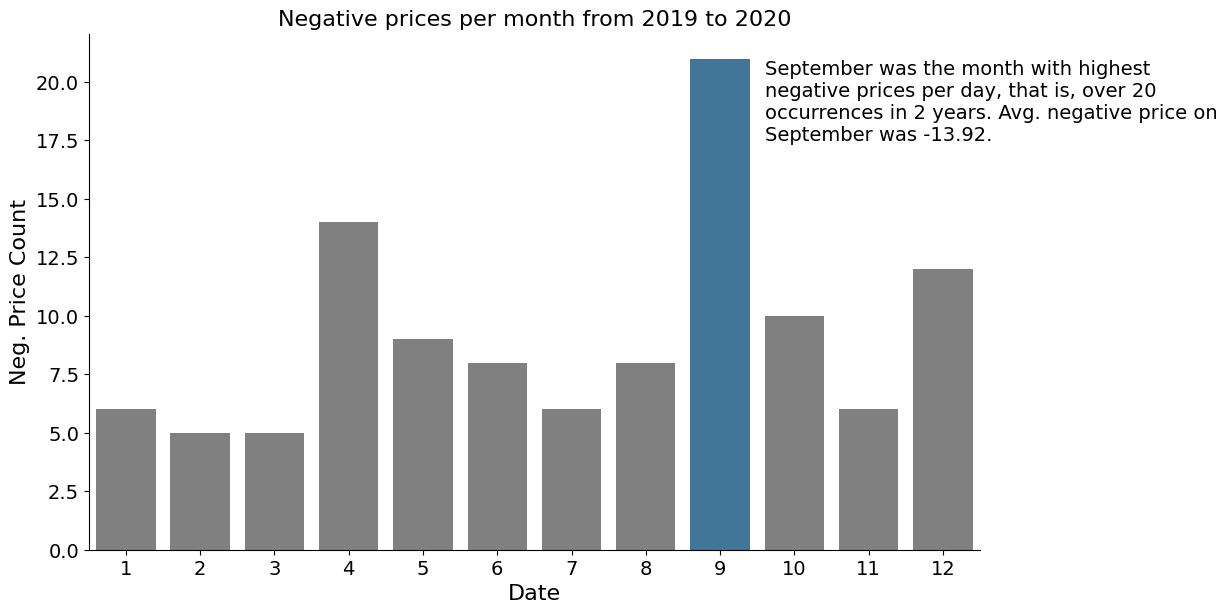

In [38]:
# filter for year 2019 and 2020
year_neg =  data[data['year'] >= 2019]
#data_group['month'] = data['date'].dt.month_name()
#months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
#          'August', 'September', 'October', 'November', 'December']
months = [1,2,3,4,5,6,7,8,9,10,11,12]
colors = ['#3279a8' if (x == 9) else 'gray' for x in months]
avg_neg_price = data[(data['year'] >= 2019) & (data['month'] == 9)]['price_negative'].mean()

g = sns.catplot(data=year_neg, x='month', kind='count', height=6, aspect=10/6,
                palette=colors, order=months)

# annotate the graph 
g.axes.flat[0].text(s=f"""September was the month with highest
negative prices per day, that is, over 20
occurrences in 2 years. Avg. negative price on
September was {str(round(avg_neg_price,2))}.""", x=8.6, y=17.5,
fontsize=14)

# set axis labels and titles
g.set_axis_labels('Date', 'Neg. Price Count')
plt.title('Negative prices per month from 2019 to 2020', fontsize=16)

fig.autofmt_xdate()
plt.show()

Now let's calculate the average value of the electricity produced by a solar array, making the following assumptions:
- Using the prices for 2017-2019 (inclusive)
- Solar array is functional 100% of the time
- All of the electricity is sold at the average daily price (solar power peaks at midday while prices may not so this assumption is probably not true)

The average value of the electricity produced by a solar array is slightly more than the yearly average price since it is mostly produced in the summer where we have peaks in demand: 108.9 AUD/MWh vs 102.2 AUD/MWh.

In [39]:
# subset data for values between 2017 and 2019
price_1719 = energy_dmd['2017-01-01':'2019-12-31']

# calculate the weighted avearge and print
# out the value
weighted_average_price = (price_1719.solar_exposure * price_1719.price).sum()/price_1719.solar_exposure.sum()

print(f"Weighted average value of electricity produced by solar array: {weighted_average_price:.1f} AUD/MWh")

Weighted average value of electricity produced by solar array: 108.9 AUD/MWh


## Return on investment for solar panels
Given that a solar array produces electricity valued at 108.9 AUD/MWh on average, is it actually worth building solar arrays? And how long would it take for a solar array to pay back for itself?

Let's start by calculating the value of the electricity per unit area generated by the solar array over a year:

In [40]:
avg_price = 108.9
PV_efficiency = 0.2
electricity_values = energy_dmd[energy_dmd.year != 2020].groupby('year').solar_exposure.sum() * PV_efficiency * avg_price
mean_profit, error_in_mean = electricity_values.mean(), electricity_values.sem()

print(f"Assuming projected average price of {avg_price:.1f} AUD/MWh and solar cell efficiency of {PV_efficiency*100:.1f}%"
      f", mean yearly profit for 2015-2019 is {mean_profit:.1f} +/- {error_in_mean:.1f} AUD/m^2")

Assuming projected average price of 108.9 AUD/MWh and solar cell efficiency of 20.0%, mean yearly profit for 2015-2019 is 33.3 +/- 0.2 AUD/m^2


I can buy a 0.715 m x 0.810 m panel from [HomeDepot](https://images.thdstatic.com/catalog/pdfImages/d3/d30b0bf3-e332-4ba8-852f-80aedabf1c70.pdf) for around $100. Presumably you get a discount if you're buying in bulk so let's say you get a generous 50% discount. The price per square meter is then

In [41]:
discount = 0.5
price = 100
length = 0.810
width = 0.715
panel_cost = (1-discount) *price / (length*width)
print(f"Solar panel cost estimate: {panel_cost:.1f} AUD/m^2")

Solar panel cost estimate: 86.3 AUD/m^2


and the ROI is:

In [42]:
print(f"Yearly ROI: {mean_profit/panel_cost * 100:.1f} %")

Yearly ROI: 38.6 %


Based on this, a solar array in Melbourne is a great investment. The ROI above does not take into account installation and maintenance costs, or the degradation of the solar panels over time. With these factors included, the costs may go up significantly, and the efficiency of the panels will also lower over time, resulting in smaller profits. However, taking the lifetime of a solar panel to be [25-30 years](https://news.energysage.com/how-long-do-solar-panels-last/), they will have ample time to pay back for themselves (around 10 years, even if we triple the cost per square meter assumed here). 

## Sell high, buy low using battery storage
Exploring the prospect of using battery storage to store some of the energy produced when prices are low to then sell it for a higher price later.

To keep things simple, I'm making a few simplifying assumptions:
- If predicted price for tomorrow is higher than for today, I'm fully filling up the batteries (if the solar arrays aren't producing, just get electricity from the grid).
- Ignore costs due to battery cycling. Batteries can undergo a finite number of charge-discharge cycles, after which they need to be replaced, but I'm ignoring any costs due to this (and these costs are likely to be high)

### Cost for a 70 MWh battery
The cost per unit capacity for lithium ion batteries is something like 120-350 USD/kWh = 170-490 AUD/kWh ([National Renewable Energy Laboratory](https://www.nrel.gov/docs/fy21osti/79236.pdf), estimate for [Tesla](https://www.forbes.com/sites/greatspeculations/2021/12/01/are-battery-cost-improvements-still-a-big-driver-of-teslas-margins/?sh=447fbdcb4ae7), [Wikipedia](https://en.wikipedia.org/wiki/Sodium-ion_battery#Advantages_and_disadvantages_over_other_battery_technologies)), so a 70 MWh battery would cost around 12 - 34 million AUD.

In [43]:
battery_price_per_kWh = 170
battery_price = (70000 * battery_price_per_kWh) / 1e6
print(f"Cost for 70 MWh battery at {battery_price_per_kWh:.1f} AUD/kWh is {battery_price:.2f} million AUD")

Cost for 70 MWh battery at 170.0 AUD/kWh is 11.90 million AUD


### How well is it possible to do in theory?
If we were able to predict the future perfectly, how much money could we make using a 70 MWh battery system? The strategy would be to fill up the batteries whenever today's price is lower than tomorrow's.

Calculate the profit that would be made everyday:

In [44]:
# create new columns to test the theory
energy_dmd['price_tomorrow'] = energy_dmd.price.shift(-1,'D')
energy_dmd['fill_battery'] = energy_dmd.price_tomorrow > energy_dmd.price
energy_dmd['profit'] = (energy_dmd.price_tomorrow - energy_dmd.price)*energy_dmd.fill_battery*70

Total profit over the entire time period is then roughly \\$1.8M, which corresponds to a daily profit of roughly 860 AUD (314,000 AUD yearly)

In [45]:
# calculate total_profit
total_profit = energy_dmd.profit.sum()/1e6
print(f"Total maximum profit over time period in data: {total_profit:.2f} million AUD")

daily_profit = energy_dmd.profit.mean()
print(f"Mean daily profit over time period in data: {daily_profit:.0f} AUD ({daily_profit*365/1e3:.1f}k AUD yearly)")

annual_ROI = daily_profit*365/(battery_price*1e6)
print(f"Maximal yearly ROI for battery: {annual_ROI*100:.1f}%")

Total maximum profit over time period in data: 1.81 million AUD
Mean daily profit over time period in data: 861 AUD (314.3k AUD yearly)
Maximal yearly ROI for battery: 2.6%


The **maximum yearly return on investment is thus approximately 2.6%**, which is very low compared to typical returns for stocks and comparable to government bonds, with the caveat that the calculation here isn't taking into account account the depreciation of the batteries (which would further reduce the ROI). It would take the batteries roughly **40 years to pay back for themselves**, and it seems unlikely they would remain functional for that long.

### To charge or not to charge: using LGBM to predict tomorrow's electricity price
In practice we don't have perfect information about tomorrow's electricity prices, so we are probably not able to reach the theoretical maximum profit for the battery system. It may be possible to predict whether or not tomorrow's price is higher than today's using machine learning, and make the decision to fill or not to fill the batteries based on a predictive model. In this section, I'm going to train a a gradient boosted tree ([LightGBMRegressor](https://lightgbm.readthedocs.io/en/latest/)) regression model to predict the price of electricity on a given day, provided the following information:
- Price of electricity for the past 7 days. We would probably have access to this data by the time we have to decide if we want to charge the batteries for tomorrow (current days prices might not be available in practice, but I'll assume they are for now).
- Weather info: min and max temperature, rainfall and solar exposure for the day. Weather forecasts are typically quite accurate for the next day, so we would have access to good approximations of this information.
- Historic electricity demand for the given day
- What day of the week is the day we are trying to predict, and is it a holiday

The code below generates the training data, fits the model, makes predictions and calculates some metrics of how well the predictions succeeded. This is done for 5 folds of data: for each fold the training data contains the full data - n\*100 days removed from the end of the data. The 100 days after the end of the training data is then used as the validation set for each fold.

In [46]:
# create a function that generates model data
def generate_model_data(df: pd.DataFrame, N_prev = 7, N_folds = 5) -> pd.DataFrame:
    """
    Generates data that is used to train a model to predict electricity prices on a given day.
    """
    columns = ['demand',
               'price',
               'min_temperature',
               'max_temperature',
               'solar_exposure',
               'rainfall',
               'school_day',
               'holiday',
               'week']
    df = df.copy()[columns]
    
    # Get prices for N_prev days and store them as new columns
    for n in range(1,N_prev+1):
        df[f'price_{n}'] = df.price.shift(n,'D')
    
    df.attrs['N_prev'] = N_prev
        
    # Remove dates where previous prices are not available
    df.dropna(inplace = True)
    
    # Split data into folds for use in cross validation
    date_max = df.index.max()
    day = pd.Timedelta(1,'D')
    df['fold'] = 0
    for i, n in enumerate(range(N_folds,0,-1)):
        df.loc[date_max-(i+1)*100*day:date_max-i*100*day, 'fold'] = n
        
    df.reset_index(inplace = True)
        
    return df


In [47]:
# create a function that generates train and test data
def generate_train_test(df: pd.DataFrame, fold: int) -> Tuple[pd.DataFrame]:
    """
    Generates train and test datasets for a given test fold
    """
    # make a copy of the dataframe
    df = df.copy()
    
    # generate train set
    train = df[df.fold < fold]
    y_train = train.pop('price')
    X_train = train.drop(columns = ['demand','fold'])
    
    # generate test set
    test = df[df.fold == fold]
    y_test = test.pop('price')
    X_test = test.drop(columns = ['demand', 'fold'])

    return X_train, y_train, X_test, y_test

In [48]:
# create a function that generate features and 
# target variable
def get_X_y(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    """
    Separates dataframe to features and target.
    """
    
    y = df.pop('price')
    X = df.drop(columns = ['demand', 'fold'])
    
    return X, y

### Transform data
Define a pipeline for transforming data

In [49]:
def calc_weekly_median(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the median price of electricity for 
    the past 7 days for each date in data.
    """
    cols = []
    for n in range(1,df.attrs['N_prev']+1):
        cols.append(f'price_{n}')
        
    df['median_price'] = df[cols].median(axis = 1)
    
    return df
    
def calc_historical_price(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Calculates median historical price by week for each date 
    using only data that is before the validation period 
    (but not using data from future).
    """
    df = df.merge(df[df.fold < fold].groupby('week').price.median().to_frame('historical_price').reset_index(), on = 'week')
    return df

def calc_historical_demand(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Calculates median historical demand by week for each
    date in data (but not using data from future).
    """
    df = df.merge(df[df.fold < fold].groupby('week').demand.median().to_frame('historical_demand').reset_index(), on = 'week')
    return df

def transform_data(df: pd.DataFrame, fold: int) -> pd.DataFrame:
    """
    Transforms the input data to be fit by the predictive model
    """
    
    df = calc_weekly_median(df)
    df = calc_historical_price(df, fold)    
    df = calc_historical_demand(df, fold)
    
    df.set_index('date', inplace = True)

    return df

### Set up model

In [54]:
def fit_predict_LGBM(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, params: dict = {}) -> pd.DataFrame:
    """
    Sets up a linear regression model, fits it to data and makes predictions.
    """
    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    preds = X_test.copy()
    preds['predicted_price'] = y_pred
    preds['predicted_buy'] = (preds.predicted_price - preds.price_1) > 0

    return preds

### Metrics

In [55]:
def correct_buy_percentage(y_true, y_pred) -> float:
    """
    Calculates the percentage of days where the model was able to corectly predict
    if the battery should be filled or not.
    """
    return np.mean(y_true==y_pred)

def percentage_of_max_profit(df) -> float:
    """
    Calculates the percentage of the max profit that was obtained.
    """
    return df.profit.sum()/df.max_profit.sum()

### CROSS-VALIDATION

In [58]:
def cross_validate_LGBM(N_folds: int = 5, params: dict = {}):
    """
    Repeats the data generation, training, and testing of the model for
    different folds.
    """
    
    data_all_folds = generate_model_data(energy_dmd)
    
    result_dict = {}
    result_dict['mape'] = []
    result_dict['cbp'] = []
    result_dict['pomp'] = []
    
    # Loop over the folds
    for fold in range(1, N_folds+1):
        data = transform_data(data_all_folds, fold)
        X_train, y_train, X_test, y_test = generate_train_test(data, fold)
        preds = fit_predict_LGBM(X_train, y_train, X_test, params=params)
        
        # Calculate data needed for calculating metrics
        preds['true_price'] = y_test
        preds['true_buy'] = (preds.true_price - preds.price_1) > 0
        preds['profit'] = (preds.true_price - preds.price_1)*preds.predicted_buy*70
        preds['max_profit'] = (preds.true_price - preds.price_1)*preds.true_buy*70
        
        # Calculate metrics
        mape = MAPE(preds.true_price, preds.predicted_price)
        cbp = correct_buy_percentage(preds.true_buy, preds.predicted_buy)
        pomp = percentage_of_max_profit(preds)
        
        result_dict['mape'].append(mape)
        result_dict['cbp'].append(cbp)
        result_dict['pomp'].append(pomp)
    
    return result_dict

def show_summary_stats(results_dict: dict):
    """
    Print the the mean and error in mean accross different folds
    """
    for metric, values in results_dict.items():
        mean = np.mean(values)
        std_err = sem(values)
        print(f"Mean for {metric}: {mean:.3f}+/-{std_err:.3f}")

#### Test the model
The metrics that are printed are:
- 'mape': mean absolute percentage error, smaller is better
- 'cbp': correct buy percentage - the percentage of times when the prediction of the model results in correctly charging or not charging the batteries. Larger is better
- 'pomp': percentage of maximum profits - the percentage of the maximum profit that the model achieved (max profit would be made if the prices for tomorrow were fully known

The percentage of maximum profits is the most important one of these, since profits are ultimately what determines if the battery system is a good investment or not, and this is what the model should ultimately be optimized for.

In [59]:
params = {"num_iterations": 200, "learning_rate": 0.05, "num_leaves": 8}
results = cross_validate_LGBM(params = params)
show_summary_stats(results)

Mean for mape: 0.388+/-0.087
Mean for cbp: 0.641+/-0.009
Mean for pomp: 0.477+/-0.036


# Our model was fit to the data up until December, 31st 2019 and...

In [ ]:
# split data into train and test
train = energy_dmd['price'].iloc[:-279]
test = energy_dmd['price'].iloc[-279:]

# instantiate the model and fit to the train set
model = SARIMAX(train, order=(4,0,0), seasonal_order=(3,0,1,7),
                simple_differencing=False)
model_fit = model.fit(disp=False)

## Our has a mean absolute error of 1.64% which means that it predictions are 1.64% off from the actual values

In [ ]:
# create subplots and get model predictions
fig, ax = plt.subplots(figsize=(10,8))
predictions = model_fit.get_prediction(1828, 2106).predicted_mean

# plot the test and prediction and compare
ax.plot(test, 'b-', label='actual')
ax.plot(predictions, 'k-.', label='predictions')

# set axis label, title and align date properly
ax.set_xlabel('Time')
ax.set_ylabel('Price (AUD/MWh)')
ax.set_ylim(-20, 300)
fig.autofmt_xdate()
plt.show()

In [ ]:
mape = MAPE(test, predictions)
print(f"Mean Absolute Percentage Error: {str(round(mape, 2))}%")

###### 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!